In [17]:
import pandas as pd

df = pd.read_csv(r':\Users\marco\Documents\AFC\Diffusion-Models-for-Time-Series\data\TSLA\TSLA_2015-01-02_2015-01-30\TSLA_2015-01-02_34200000_57600000_message_10.csv', header=None)
print(df.head())


              0  1        2      3        4  5
0  34200.006789  5        0     13  2228300  1
1  34200.034290  6       -1  17011  2228700 -1
2  34200.034290  1  5519048     11  2227500  1
3  34200.034290  1  2142274     10  2230000 -1
4  34200.034290  1  2629509    200  2226000  1


In [18]:
# delete column "2"
df.drop(df.columns[2], axis=1, inplace=True)

In [19]:
print(df.head())

              0  1      3        4  5
0  34200.006789  5     13  2228300  1
1  34200.034290  6  17011  2228700 -1
2  34200.034290  1     11  2227500  1
3  34200.034290  1     10  2230000 -1
4  34200.034290  1    200  2226000  1


In [20]:
# aggiungi una feature "6" che casualmente per ogni istanza può assumere valore 0 o 1 (50 e 50)
import random
random.seed(42)
df['6'] = [random.randint(0, 1) for _ in range(len(df))]
print(df.head())

              0  1      3        4  5  6
0  34200.006789  5     13  2228300  1  0
1  34200.034290  6  17011  2228700 -1  0
2  34200.034290  1     11  2227500  1  1
3  34200.034290  1     10  2230000 -1  0
4  34200.034290  1    200  2226000  1  0


In [21]:
# rename columns as "time", "event_type", "size", "price", "direction", "generated"
df.columns = ["time", "event_type", "size", "price", "direction", "generated"]
print(df.head())

           time  event_type   size    price  direction  generated
0  34200.006789           5     13  2228300          1          0
1  34200.034290           6  17011  2228700         -1          0
2  34200.034290           1     11  2227500          1          1
3  34200.034290           1     10  2230000         -1          0
4  34200.034290           1    200  2226000          1          0


In [22]:
# direction one hot, generated one hot, price normalization between 0 and 1, size normalization between 0 and 1, event_type one hot, time divide by 100000

# direction one hot
df = pd.get_dummies(df, columns=['direction'])

# price normalization between 0 and 1
df['price'] = (df['price'] - df__['price'].min()) / (df['price'].max() - df['price'].min())

# size normalization between 0 and 1
df['size'] = (df['size'] - df['size'].min()) / (df['size'].max() - df['size'].min())

# event_type one hot
df = pd.get_dummies(df, columns=['event_type'])

# time divide by 100000
df['time'] = df['time'] / 100000

In [23]:
df.head()

,time,size,price,generated,direction_-1,direction_1,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6
0,0.342,0.000705,0.885996,0,0,1,0,0,0,0,1,0
1,0.342,1.000000,0.889587,0,1,0,0,0,0,0,0,1
2,0.342,0.000588,0.878815,1,0,1,1,0,0,0,0,0
3,0.342,0.000529,0.901257,0,1,0,1,0,0,0,0,0
4,0.342,0.011699,0.865350,0,0,1,1,0,0,0,0,0


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and it's already preprocessed
features = df.drop('generated', axis=1).values
labels = df['generated'].values

# Reshape input to be 3D [samples, timesteps, features]
features = features.reshape((features.shape[0], 1, features.shape[1]))

# Split the data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# Create data loaders
train_data = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_data, batch_size=72)
test_data = TensorDataset(test_X, test_y)
test_loader = DataLoader(test_data, batch_size=72)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size, device=device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[:, -1, :])
        return out

# Instantiate the model
model = LSTMModel(input_size=train_X.shape[2], hidden_size=128, num_layers=2, output_size=1, device=device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
for epoch in range(50):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

In [28]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists(tensors)
test_preds = torch.Tensor().to(train_X.device)
test_labels = torch.Tensor().to(train_X.device)

with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        test_preds = torch.cat((test_preds, output), dim=0)
        test_labels = torch.cat((test_labels, labels.unsqueeze(1)), dim=0)

# Apply sigmoid function to output probabilities between 0 and 1
test_preds = torch.sigmoid(test_preds)

# Convert probabilities to binary predictions (0 or 1)
test_preds_binary = (test_preds > 0.5).float()

# Calculate the accuracy of the model
accuracy = (test_preds_binary == test_labels).sum().item() / test_labels.numel()

print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 49.98%


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

# Load dataframes
d1 = pd.read_csv("d1.csv")
d2 = pd.read_csv("d2.csv")

# Split dataframes into train and test sets
d1_train, d1_test = d1[:int(len(d1)*0.8)], d1[int(len(d1)*0.8):]
d2_train, d2_test = d2[:int(len(d2)*0.8)], d2[int(len(d2)*0.8):]

# Prepare data for LSTM model
def prepare_data(df):
  # Extract features and labels
  X = df.drop("label", axis=1).values
  y = df["label"].values
  # Convert data to torch tensors
  X = torch.tensor(X, dtype=torch.float32)
  y = torch.tensor(y, dtype=torch.float32)
  # Reshape data into 3D tensor
  X = X.unsqueeze(1)
  y = y.unsqueeze(1)
  return X, y

X_train_d1, y_train_d1 = prepare_data(d1_train)
X_test_d1, y_test_d1 = prepare_data(d1_test)
X_train_d2, y_train_d2 = prepare_data(d2_train)
X_test_d2, y_test_d2 = prepare_data(d2_test)

# Define LSTM model
def define_model(input_size, hidden_size, num_layers, bidirectional):
  # Create a sequential model
  model = nn.Sequential()
  # Add a bidirectional LSTM layer
  model.add_module("lstm", nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional))
  # Add a linear layer with sigmoid activation for binary classification
  model.add_module("linear", nn.Linear(in_features=hidden_size * (2 if bidirectional else 1), out_features=1))
  model.add_module("sigmoid", nn.Sigmoid())
  # Define the optimizer and the loss function
  optimizer = torch.optim.Adam(model.parameters())
  loss_fn = nn.BCELoss()
  return model, optimizer, loss_fn

# Train LSTM model on d1
input_size = X_train_d1.shape[2]
hidden_size = 32
num_layers = 2
bidirectional = True
model_d1, optimizer_d1, loss_fn_d1 = define_model(input_size, hidden_size, num_layers, bidirectional)
epochs = 10
for epoch in range(epochs):
  # Set the model to training mode
  model_d1.train()
  # Forward pass
  output_d1, _ = model_d1(X_train_d1)
  # Compute the loss
  loss_d1 = loss_fn_d1(output_d1, y_train_d1)
  # Backward pass and update the parameters
  optimizer_d1.zero_grad()
  loss_d1.backward()
  optimizer_d1.step()
  # Print the loss
  print(f"Epoch {epoch+1}, Loss: {loss_d1.item():.4f}")

# Train LSTM model on d2
input_size = X_train_d2.shape[2]
hidden_size = 32
num_layers = 2
bidirectional = True
model_d2, optimizer_d2, loss_fn_d2 = define_model(input_size, hidden_size, num_layers, bidirectional)
epochs = 10
for epoch in range(epochs):
  # Set the model to training mode
  model_d2.train()
  # Forward pass
  output_d2, _ = model_d2(X_train_d2)
  # Compute the loss
  loss_d2 = loss_fn_d2(output_d2, y_train_d2)
  # Backward pass and update the parameters
  optimizer_d2.zero_grad()
  loss_d2.backward()
  optimizer_d2.step()
  # Print the loss
  print(f"Epoch {epoch+1}, Loss: {loss_d2.item():.4f}")

# Test LSTM models on d1 test set
# Set the models to evaluation mode
model_d1.eval()
model_d2.eval()
# Predict the labels
y_pred_d1 = model_d1(X_test_d1)
y_pred_d2 = model_d2(X_test_d1)
# Evaluate the performance of the models
from sklearn.metrics import accuracy_score
acc_d1 = accuracy_score(y_test_d1, y_pred_d1 > 0.5)
acc_d2 = accuracy_score(y_test_d1, y_pred_d2 > 0.5)
print("Accuracy of model_d1 on d1 test set:", acc_d1)
print("Accuracy of model_d2 on d1 test set:", acc_d2)


In [44]:
import pandas as pd

# open csv file as pandas dataframe
df = pd.read_csv(r'C:\Users\marco\OneDrive\Documenti\afc\afc_project\Diffusion-Models-for-Time-Series\data\TSLA\TSLA_2015-01-02_2015-01-30\TSLA_2015-01-05_34200000_57600000_message_10.csv', header=None)

In [45]:
df.head()

,0,1,2,3,4,5
0,34200.005047,4,8498383,40,2144600,1
1,34200.008011,3,8498383,160,2144600,1
2,34200.008637,3,8519079,200,2149700,-1
3,34200.043668,1,8541883,20,2143600,1
4,34200.078412,1,8555441,5000,2145000,1


In [46]:
import torch
from sklearn.decomposition import PCA
import pandas as pd


class PCA2D(torch.nn.Module):
    def __init__(self, n_components=2):
        super(PCA2D, self).__init__()
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def forward(self, x):
        x = torch.Tensor(x.values)  # Convert DataFrame to NumPy array first
        x = self.pca.fit_transform(x)
        return x
    
from sklearn.manifold import TSNE
import torch

class TSNE2D(torch.nn.Module):
    def __init__(self, n_components=2):
        super(TSNE2D, self).__init__()
        self.n_components = n_components
        self.tsne = TSNE(n_components=n_components)

    def forward(self, x):
        x = torch.Tensor(x.values)  # Convert DataFrame to NumPy array first
        x = self.tsne.fit_transform(x)
        return x

In [47]:

    
# features: "time", "event_type", "size", "price", "direction"
# time 100000, event_type onehot, size normalization [0,1], price normalization [0,1], direction onehot


# delete third column
df = df.drop(df.columns[2], axis=1)

# rename the columns into time, event_type, size, price, direction
df.columns = ['time', 'event_type', 'size', 'price', 'direction']

# divide the column time by 100000
df['time'] = df['time']/100000

# one hot encoding for the feature event_type
df = pd.get_dummies(df, columns=['event_type'])

# standardize the features size and price
df['price'] = (df['price'] - df['price'].mean())/df['price'].std()
df['size'] = (df['size'] - df['size'].mean())/df['size'].std()

# one hot encoding for the feature direction
df = pd.get_dummies(df, columns=['direction'])


In [48]:
df.head()

,time,size,price,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,direction_-1,direction_1
0,0.342000,-0.504332,2.388446,0,0,0,1,0,0,0,1
1,0.342000,0.513174,2.388446,0,0,1,0,0,0,0,1
2,0.342000,0.852343,2.674665,0,0,1,0,0,0,1,0
3,0.342000,-0.673917,2.332325,1,0,0,0,0,0,0,1
4,0.342001,41.552588,2.410895,1,0,0,0,0,0,0,1


In [49]:
# df deve essere composto solo dai primi 25000 elementi
df = df[:25000]

In [50]:
pca2d = TSNE2D(n_components=2).forward(df)

In [51]:
pca2d

array([[-110.23412 ,  -25.750635],
       [ 104.125534,  -38.905807],
       [ 101.14527 ,   46.74257 ],
       ...,
       [ -53.969532,   55.493786],
       [ -53.969532,   55.493786],
       [  20.895159,   35.52365 ]], dtype=float32)

In [52]:
df_ = pd.read_csv(r'C:\Users\marco\OneDrive\Documenti\afc\afc_project\Diffusion-Models-for-Time-Series\data\TSLA\TSLA_2015-01-02_2015-01-30\TSLA_2015-01-06_34200000_57600000_message_10.csv', header=None)

# delete third column
df_ = df_.drop(df_.columns[2], axis=1)

# rename the columns into time, event_type, size, price, direction
df_.columns = ['time', 'event_type', 'size', 'price', 'direction']

# divide the column time by 100000
df_['time'] = df_['time']/100000

# one hot encoding for the feature event_type
df_ = pd.get_dummies(df_, columns=['event_type'])

# standardize the features size and price
df_['price'] = (df_['price'] - df_['price'].mean())/df_['price'].std()
df_['size'] = (df_['size'] - df_['size'].mean())/df_['size'].std()

# one hot encoding for the feature direction
df_ = pd.get_dummies(df_, columns=['direction'])

# df_ deve essere composto solo dai primi 25000 elementi
df_ = df_[:25000]
pca2d_ = TSNE2D(n_components=2).forward(df_)

In [53]:
print(pca2d_)

[[-72.32891  -77.348495]
 [109.43206  -20.044518]
 [-72.32898  -77.34846 ]
 ...
 [-40.43158  110.71203 ]
 [-98.48109    2.955264]
 [-32.66316  -23.485533]]


In [54]:
# print len pca2d
print(len(pca2d))

25000


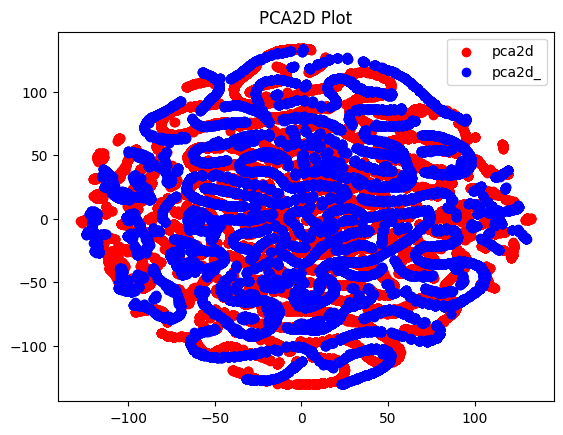

In [55]:
import matplotlib.pyplot as plt

# Plot pca2d in red
plt.scatter(pca2d[:, 0], pca2d[:, 1], color='red', label='pca2d')

# Plot pca2d_ in blue
plt.scatter(pca2d_[:, 0], pca2d_[:, 1], color='blue', label='pca2d_')

# Add legend and title
plt.legend()
plt.title('PCA2D Plot')

# Show the plot
plt.show()

######### QUESTO è ESEMPIO TSNE #########